In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 
conn = engine.connect()

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(text(query), con=conn) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('MONTH', creation_date)::date AS month_date,
    SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('MONTH', creation_date)::date
HAVING SUM(views_count) > 0
ORDER BY total_views DESC
'''
pd.read_sql_query(text(query), con=conn)
# выполните запрос

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


<details>

<summary>Подсказка</summary>
Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Данные отличаются, по следующим причинам:
- Июль, август - летние месяцы период отпусков и каникул, меньше вопросов по учебе и работе,
- В сентябре и октябре резко повышается активность, люди выходят с отпусков и каникул и освежают знания,
- К ноябрю активность спадает все входят в обычный ритм, а в декабре начинаются предпраздничная суета и праздники.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
WiTH t1 AS (
SELECT u.display_name AS display_name
FROM stackoverflow.users AS u 
INNER JOIN stackoverflow.posts AS p ON u.id = p.user_id
WHERE u.creation_date :: date + 30 >= p.creation_date :: date 
    AND post_type_id = (
    SELECT id
    FROM stackoverflow.post_types
    WHERE type = 'Answer')
GROUP BY u.display_name
HAVING count(u.display_name) > 100 
ORDER BY display_name)

SELECT t1.display_name AS display_name, count(u.id)
FROM stackoverflow.users AS u 
INNER JOIN t1 ON t1.display_name = u.display_name
GROUP BY t1.display_name
ORDER BY display_name
'''

# выполните запрос
sample_df=pd.read_sql_query(text(query), con=conn)

In [8]:
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,11
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


In [9]:
sample_df.loc[sample_df['count'] > 1]

,display_name,count
4,Alan,11
7,Brian,27
10,Chris,52
12,Craig,14
14,Dan,33
21,Greg,19
25,Jim,16
26,Joe,20
33,Josh,18
34,Keith,8


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

Поля count больше одного, это значит что для ряда записей display_name совпадает и display_name не уникальное поле. И поиск через имя не совсем коректен, необходимо искать через user_id.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [10]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('MONTH', p.creation_date)::date AS month_date,
    count(p.id) AS total_views
FROM stackoverflow.posts AS p
WHERE user_id in (
    SELECT distinct u.id
    FROM stackoverflow.posts AS p
    INNER JOIN stackoverflow.users AS u ON u.id = p.user_id
    WHERE DATE_TRUNC('MONTH', u.creation_date)::date = '2008-09-01' 
        AND DATE_TRUNC('MONTH', p.creation_date)::date = '2008-12-01'
)
GROUP BY DATE_TRUNC('MONTH', p.creation_date)::date
ORDER BY month_date DESC
'''
pd.read_sql_query(text(query), con=conn)
# выполните запрос

,month_date,total_views
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

Есть 32 записи в августе, хотя пользователи не были зарегистрированы в это время. Есть возможных причины.
- Время регистрации пользователя и время создание поста происходить по разным часовым поясам, регистрация может быть местному времени, а регистрация поста по серверному, например человек из Европы регистрируется у него уже сентябрь, и сразу публикует пост, и пост регистрируется по времени США и оно еще в августе.
- Эта причина маловероятно но, id_users были присвоены из старого пула, и посты других пользователей записались на новых.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [11]:
# напишите запрос
query = '''
SELECT user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER (PARTITION BY user_id ORDER BY user_id, creation_date) AS cumulative_count
FROM stackoverflow.posts
'''

# выполните запрос
pd.read_sql_query(text(query), con=conn)

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [12]:
# напишите запрос
query = '''
WITH t1 AS (
SELECT user_id,
       creation_date::date AS day,
       count(id) AS day_count
FROM stackoverflow.posts
WHERE creation_date::date >= '2008-08-01' AND  creation_date::date <= '2008-08-31'
GROUP BY user_id, creation_date::date)

SELECT user_id, 
    AVG(day_count) AS avg_daily
FROM t1
GROUP BY user_id
HAVING SUM(day_count) >120
ORDER BY avg_daily
'''

# выполните запрос
pd.read_sql_query(text(query), con=conn)

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [13]:
# напишите запрос
query = '''
WITH T1 AS (

SELECT user_id,
    creation_date::date AS date,
    DENSE_RANK() OVER (PARTITION BY user_id ORDER BY creation_date::date) as day_number
FROM stackoverflow.posts
WHERE creation_date::date >= '2008-12-01' AND  creation_date::date <= '2008-12-07'
),

T2 AS (
SELECT DISTINCT user_id,
    LAST_VALUE(day_number) OVER 
        (PARTITION BY user_id ORDER BY day_number ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS day_number
FROM T1)    

SELECT ROUND(AVG(day_number), 0) AS result
FROM T2
'''

# выполните запрос
pd.read_sql_query(text(query), con=conn)

,result
0,2.0


<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

Пользовали в среднем заходя два дня из 7 (недели), не так уж часто для соц. сети.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [14]:
# напишите запрос
query = '''
SELECT user_id,
    creation_date,
    to_char(
        LAG(creation_date, 2) OVER (PARTITION BY user_id ORDER BY user_id, creation_date), 'Month') AS second_last_month
FROM stackoverflow.posts
'''

# выполните запрос
pd.read_sql_query(text(query), con=conn)

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


<details>

<summary>Подсказка</summary>
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.
</details>

# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [15]:
# напишите запрос
query = '''
WITH t1 AS (
SELECT user_id,
    DATE_TRUNC('MONTH', MIN(creation_date))::date AS cohort_dt
FROM stackoverflow.posts
GROUP BY user_id),

t2 AS (
SELECT cohort_dt,
    DATE_TRUNC('month', creation_date)::date AS session_date,
    COUNT(DISTINCT p.user_id) AS users_cnt
FROM t1 
JOIN stackoverflow.posts  AS p ON t1.user_id = p.user_id
GROUP BY 1, 2)

SELECT cohort_dt,
       session_date,
       users_cnt,
       FIRST_VALUE(users_cnt) OVER (PARTITION BY cohort_dt ORDER BY session_date) AS cohort_users_cnt,
       ROUND((users_cnt::numeric /FIRST_VALUE(users_cnt) OVER (PARTITION BY cohort_dt ORDER BY session_date)) * 100, 2) AS retention_rate
FROM t2

'''

# выполните запрос
sample_df = pd.read_sql_query(text(query), con=conn)

In [16]:
sample_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<details>

<summary>Подсказка</summary>
Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:

- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [17]:
# постройте тепловую карту Retention Rate

<ipython-input-18-72cea4c31eba>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')


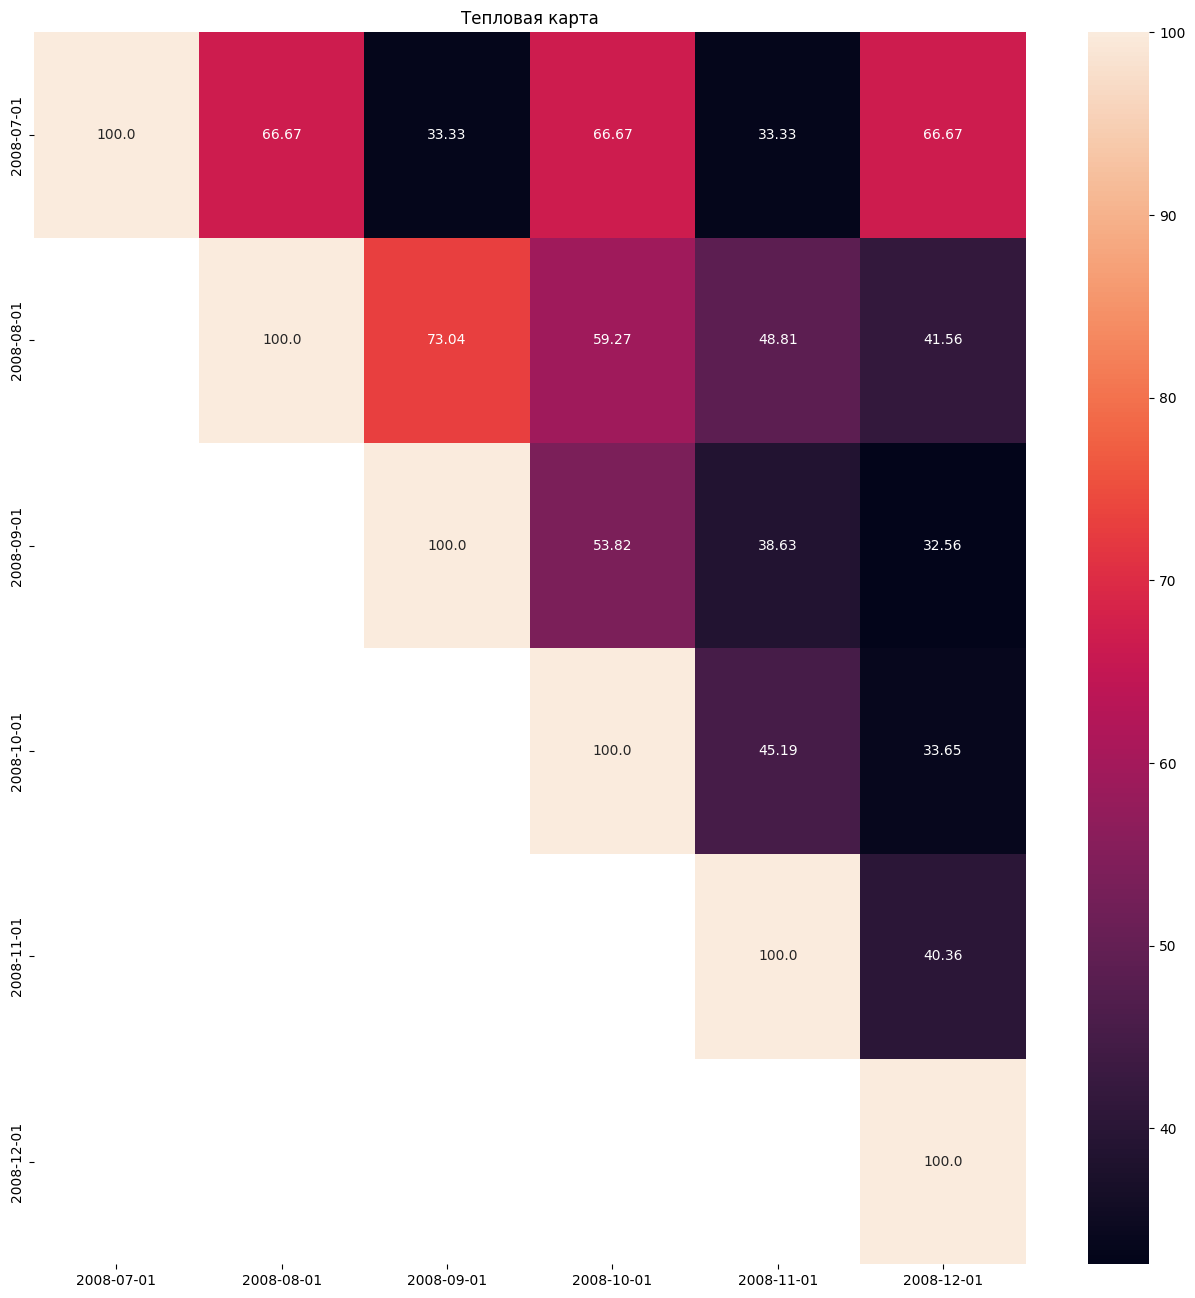

In [18]:
# создаём сводную таблицу с результатами
retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

- Мало пользователей в июле всего 3, которые публикуют то, по 2 то по 1 пользователю из когорты поочерёдно, очень странно, похожи на тестовых пользователей;
- Если не брать во внимание июнь то видно, что с каждой когортой интерес падает на второй месяц использования все сильнее;
- Августовская когорта самая преданная;
- Сентябрь и октябрь, это люди которые пришли освежить знания в начале работы и учебы после каникул отпусков, решили все проблемы и ушли с платформы. 

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [19]:
# напишите запрос
query = '''
WITH t1 AS (
SELECT DISTINCT
    EXTRACT(MONTH FROM(creation_date))::int AS creation_month,
    COUNT(id) OVER (PARTITION BY EXTRACT(MONTH FROM(creation_date))) AS posts_count 
FROM stackoverflow.posts
WHERE creation_date::date >= '2008-09-01' AND  creation_date::date <= '2008-12-31')

SELECT creation_month,
    posts_count,
    ROUND(
    ((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) *100, 2
    ) AS percentage
FROM t1
'''

# выполните запрос
sample_df = pd.read_sql_query(text(query), con=conn)

In [20]:
sample_df

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


<div class="alert alert-block alert-info">

### Комментарий студента: 
Поправил.

</div>

<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

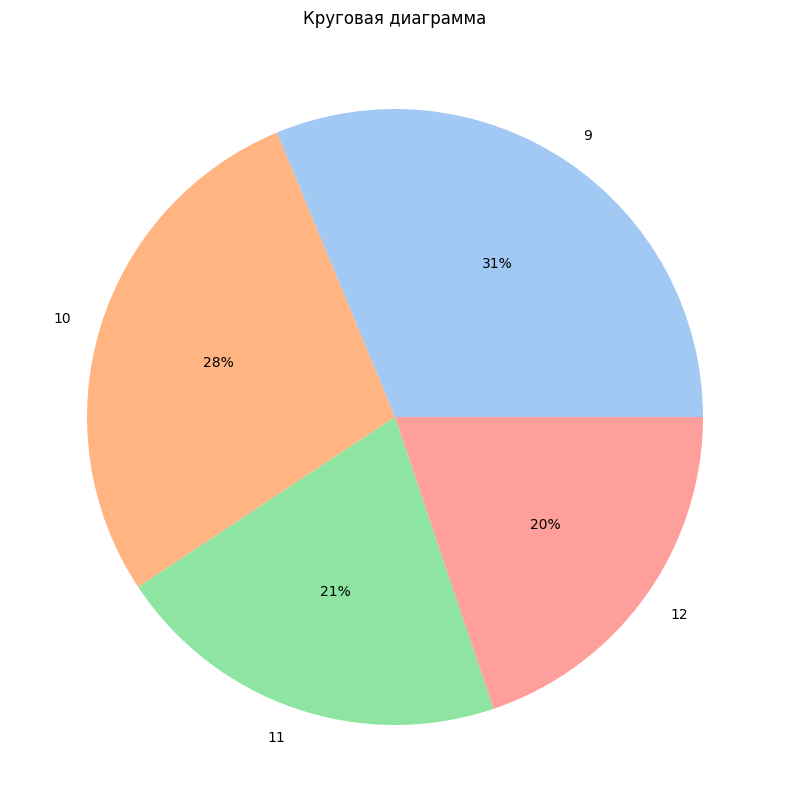

In [21]:
# постройте круговую диаграмму с количеством постов по месяцам
colors = sns.color_palette('pastel')[ 0:5 ] # цветовая схема

plt.figure(figsize=(10, 10)) # задаём размер графика
plt.pie(sample_df['posts_count'], labels = sample_df['creation_month'], colors = colors, autopct='%.0f%%')
plt.title('Круговая диаграмма')
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [22]:
# напишите запрос
query = '''
SELECT DISTINCT EXTRACT(WEEK FROM creation_date)::int as week_creation,
    LAST_VALUE(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date)::int ORDER BY creation_date 
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS creation_date
FROM stackoverflow.posts
WHERE creation_date::date >= '2008-10-01' 
    AND  creation_date::date <= '2008-10-31' 
    AND user_id = (SELECT user_id
                FROM stackoverflow.posts 
                GROUP BY user_id
                ORDER BY COUNT(id) DESC
                LIMIT 1)
'''

# выполните запрос
pd.read_sql_query(text(query), con=conn)

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01


<details>

<summary>Подсказка</summary>
Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>